In [1]:
import pandas as pd
from pathlib import Path
import sys
from time import time
sys.path.append(str(Path.cwd().parents[1]))

from logger import logger
from utilities import get_region_border, set_catch_ratio
from plot_data import plot_all_catches
from fetch_data import fetch_data_from_fiskeridirektoratet, fetch_data_from_copernicus_marine

/home/anna/msc_oppgave/fish-forecast/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
REGIONS_PATH = '/home/anna/msc_oppgave/fish-forecast/areas.json'
MAC_REGIONS = ["FA_Makrell_JulNov_winter_download"]
MAC_TIMES = {"FA_Makrell_JulNov_winter_download": ['06-01', '11-30']}

years = [2011, 2024] # start and end year for the data to inspect

region_coords = get_region_border(REGIONS_PATH, MAC_REGIONS[0])
df_full = pd.DataFrame()

for y in range(years[0], years[1] + 1):
	test_params_fdir = {
				"dataset_path": "/home/anna/msc_oppgave/data/fiskeridirektoratet/",
				"time": [f"{y}-{MAC_TIMES[MAC_REGIONS[0]][0]}", f"{y}-{MAC_TIMES[MAC_REGIONS[0]][1]}"],
				"species": "MAC"
			}

	test_params_fdir.update(region_coords)
	ds = fetch_data_from_fiskeridirektoratet(test_params_fdir, day_samples=False)

	ds = set_catch_ratio(test_params_fdir, ds, 1.0, method='continuous')

	df_full = pd.concat([df_full, ds])

df_full = df_full.reset_index(drop=True)
# df_full.to_csv(f"data_download_area_{years[0]}_{years[1]}_jul_nov.csv", sep=';', index=False)



19:59:30.273 | DEBUG    | /home/anna/msc_oppgave/fish-forecast/fetch_data.py:102 - Searching years: 2011 - 2011
19:59:30.274 | DEBUG    | /home/anna/msc_oppgave/fish-forecast/fetch_data.py:112 - Searching for fish species: MAC
19:59:35.535 | DEBUG    | /home/anna/msc_oppgave/fish-forecast/fetch_data.py:130 - First and last entry for year 2011: 01.06.2011 09:56:00 - 25.08.2011 06:54:00
19:59:35.535 | DEBUG    | /home/anna/msc_oppgave/fish-forecast/fetch_data.py:132 - Data for year 2011 shape: (1573, 9)
19:59:35.547 | DEBUG    | /home/anna/msc_oppgave/fish-forecast/fetch_data.py:143 - Dataframe shape after removing outside ROI catch: (1573, 12)
19:59:35.551 | INFO     | /home/anna/msc_oppgave/fish-forecast/fetch_data.py:175 - Final dataset shape: (1573, 5)
19:59:35.566 | INFO     | /home/anna/msc_oppgave/fish-forecast/utilities.py:133 - Period used (%): 105/183 = 57.38% -> Days w/o: 78
19:59:35.569 | INFO     | /home/anna/msc_oppgave/fish-forecast/utilities.py:171 - Dates with catch (%):

Unique catch days: 1528, total catches: 26255


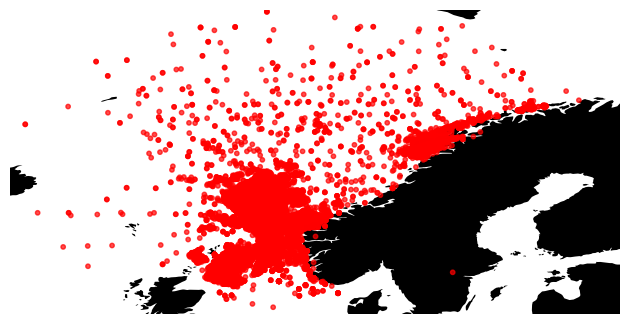

Unique catch days without June: 1310, total catches: 24393


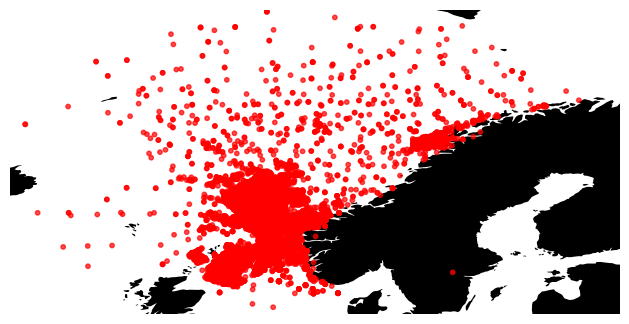

In [7]:
unique_catch_days = df_full['Date'].unique()
print(f"Unique catch days: {len(unique_catch_days)}, total catches: {df_full.shape[0]}")

plot_all_catches(df_full, region_coords, use_catch_weight=False) 

df_woJUN = df_full[df_full['Date'].dt.month != 6]
print(f"Unique catch days without June: {len(df_woJUN['Date'].unique())}, total catches: {df_woJUN.shape[0]}")
plot_all_catches(df_woJUN, region_coords, use_catch_weight=False)

In [ ]:


dataset_dict = {
    "dataset_id": "cmems_mod_glo_phy_my_0.083deg_P1D-m",
    "longitude": [region_coords["SW"]["lon"], region_coords["SE"]["lon"]],
    "latitude": [region_coords["SW"]["lat"], region_coords["NE"]["lat"]],
    "time": [f"2021-06-30T00:00:00", f"2021-06-30T00:00:00"],
    "variables": ["bottomT", "mlotst", "siconc", "sithick", "so", "thetao", "uo", "usi", "vo", "vsi", "zos"]
}

copernicus_data = fetch_data_from_copernicus_marine(dataset_dict)
copernicus_data.to_netcdf('/home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/test_ds.nc')
copernicus_data

INFO - 2025-06-21T17:06:02Z - Selected dataset version: "202311"
INFO - 2025-06-21T17:06:02Z - Selected dataset part: "default"


<xarray.Dataset> Size: 109MB
Dimensions:    (depth: 50, latitude: 256, longitude: 256, time: 1)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 1kB 55.17 55.25 55.33 ... 76.25 76.33 76.42
  * longitude  (longitude) float32 1kB -3.167 -3.083 -3.0 ... 17.92 18.0 18.08
  * time       (time) datetime64[ns] 8B 2021-06-30
Data variables:
    bottomT    (time, latitude, longitude) float64 524kB ...
    mlotst     (time, latitude, longitude) float64 524kB ...
    siconc     (time, latitude, longitude) float64 524kB ...
    sithick    (time, latitude, longitude) float64 524kB ...
    so         (time, depth, latitude, longitude) float64 26MB ...
    thetao     (time, depth, latitude, longitude) float64 26MB ...
    uo         (time, depth, latitude, longitude) float64 26MB ...
    usi        (time, latitude, longitude) float64 524kB ...
    vo         (time, depth, latitude, longitude) float64 26MB ...
    vsi        (time, latitude, longitude) float64 524kB ...
    zos        (time, latitude, longitude) float64 524kB ...
Attributes:
    Conventions:  CF-1.4
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    institution:  MERCATOR OCEAN
    source:       MERCATOR GLORYS12V1
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr

In [ ]:
start_time = time()
copernicus_data_square.to_netcdf('/home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/test_ds_download.nc')
save_time = time() - start_time
logger.info(f"Saving took {save_time} seconds")

# check the size of a file
file_path = Path('/home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/test_ds_square.nc')
file_size = file_path.stat().st_size / 1_000_000  # size in MB
logger.info(f"File size: {file_size:.2f} MB")

17:28:39.273 | INFO     | /tmp/ipykernel_313198/1228870006.py:4 - Saving took 33.51882219314575 seconds
17:28:39.274 | INFO     | /tmp/ipykernel_313198/1228870006.py:9 - File size: 82.80 MB


In [ ]:
# # Plot all catches in the square region for each month
# path = Path('/home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/')
# save_path = path / 'mac_catches_download_region'
# save_path.mkdir(parents=True, exist_ok=True)
# for year in range(years[0], years[1] + 1):
# 	df_year = df_full[df_full['Date'].dt.year == year]
# 	for month in df_year['Date'].dt.month.unique():
# 		month_data = df_year[df_year['Date'].dt.month == month]
# 		days = len(month_data['Date'].unique())
# 		samples = len(month_data)
# 		print(f"Plotting for month {month}/{year} with {len(month_data['Date'].unique())}days, and {len(month_data)} data points")
# 		start_time = time()
# 		save_path_month = save_path / f"{month:02d}"
# 		save_path_month.mkdir(parents=True, exist_ok=True)
# 		plot_all_catches(month_data, region_coords, save_path=f"{save_path_month}/{year}_{days}d_{samples}s.jpg", use_catch_weight=False)
# 		logger.info(f"Plotting for month {month}/{year} took {time() - start_time} seconds")

17:58:57.794 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2011_7d_20s.jpg
17:58:57.795 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2011 took 0.14963436126708984 seconds


Plotting for month 1/2011 with 7days, and 20 data points
Plotting for month 6/2011 with 21days, and 145 data points


17:58:57.954 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2011_21d_145s.jpg
17:58:57.954 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2011 took 0.158250093460083 seconds
17:58:58.105 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2011_20d_103s.jpg
17:58:58.105 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2011 took 0.14968466758728027 seconds


Plotting for month 7/2011 with 20days, and 103 data points
Plotting for month 8/2011 with 16days, and 91 data points


17:58:58.259 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2011_16d_91s.jpg
17:58:58.260 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2011 took 0.1536238193511963 seconds


Plotting for month 9/2011 with 29days, and 986 data points


17:58:58.491 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2011_29d_986s.jpg
17:58:58.491 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2011 took 0.22984075546264648 seconds
17:58:58.676 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2011_14d_234s.jpg
17:58:58.677 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2011 took 0.18432211875915527 seconds


Plotting for month 10/2011 with 14days, and 234 data points
Plotting for month 11/2011 with 5days, and 14 data points


17:58:58.827 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2011_5d_14s.jpg
17:58:58.827 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2011 took 0.148789644241333 seconds
17:58:58.971 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2011_2d_2s.jpg
17:58:58.972 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2011 took 0.14334487915039062 seconds


Plotting for month 12/2011 with 2days, and 2 data points
Plotting for month 5/2012 with 3days, and 6 data points


17:58:59.117 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/05/2012_3d_6s.jpg
17:58:59.117 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 5/2012 took 0.14301753044128418 seconds
17:58:59.265 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2012_18d_82s.jpg
17:58:59.266 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2012 took 0.14728832244873047 seconds


Plotting for month 6/2012 with 18days, and 82 data points
Plotting for month 7/2012 with 5days, and 9 data points


17:58:59.413 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2012_5d_9s.jpg
17:58:59.413 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2012 took 0.1457993984222412 seconds
17:58:59.561 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2012_15d_55s.jpg
17:58:59.561 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2012 took 0.14622879028320312 seconds


Plotting for month 8/2012 with 15days, and 55 data points
Plotting for month 9/2012 with 28days, and 824 data points


17:58:59.773 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2012_28d_824s.jpg
17:58:59.774 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2012 took 0.21076178550720215 seconds
17:58:59.937 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2012_24d_301s.jpg
17:58:59.937 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2012 took 0.16234707832336426 seconds


Plotting for month 10/2012 with 24days, and 301 data points
Plotting for month 11/2012 with 4days, and 5 data points


17:59:00.079 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2012_4d_5s.jpg
17:59:00.080 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2012 took 0.14153409004211426 seconds
17:59:00.247 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2012_3d_5s.jpg
17:59:00.247 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2012 took 0.16579198837280273 seconds


Plotting for month 12/2012 with 3days, and 5 data points
Plotting for month 6/2013 with 24days, and 180 data points


17:59:00.406 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2013_24d_180s.jpg
17:59:00.407 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2013 took 0.1571352481842041 seconds
17:59:00.553 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2013_26d_84s.jpg
17:59:00.554 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2013 took 0.14528560638427734 seconds


Plotting for month 7/2013 with 26days, and 84 data points
Plotting for month 8/2013 with 13days, and 49 data points


17:59:00.697 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2013_13d_49s.jpg
17:59:00.697 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2013 took 0.14213085174560547 seconds
17:59:00.887 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2013_29d_593s.jpg
17:59:00.888 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2013 took 0.18898487091064453 seconds


Plotting for month 9/2013 with 29days, and 593 data points
Plotting for month 10/2013 with 25days, and 445 data points


17:59:01.063 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2013_25d_445s.jpg
17:59:01.063 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2013 took 0.17407655715942383 seconds
17:59:01.203 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2013_2d_2s.jpg
17:59:01.203 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2013 took 0.1384265422821045 seconds


Plotting for month 11/2013 with 2days, and 2 data points
Plotting for month 12/2013 with 1days, and 1 data points


17:59:01.347 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2013_1d_1s.jpg
17:59:01.347 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2013 took 0.14243555068969727 seconds
17:59:01.485 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/05/2014_2d_2s.jpg
17:59:01.486 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 5/2014 took 0.13674402236938477 seconds


Plotting for month 5/2014 with 2days, and 2 data points
Plotting for month 6/2014 with 27days, and 380 data points


17:59:01.657 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2014_27d_380s.jpg
17:59:01.657 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2014 took 0.16983652114868164 seconds
17:59:01.806 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2014_1d_1s.jpg
17:59:01.806 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2014 took 0.1474916934967041 seconds


Plotting for month 7/2014 with 1days, and 1 data points
Plotting for month 8/2014 with 21days, and 123 data points


17:59:01.979 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2014_21d_123s.jpg
17:59:01.980 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2014 took 0.17223453521728516 seconds


Plotting for month 9/2014 with 28days, and 947 data points


17:59:02.195 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2014_28d_947s.jpg
17:59:02.195 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2014 took 0.21431541442871094 seconds
17:59:02.373 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2014_28d_453s.jpg
17:59:02.373 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2014 took 0.17657804489135742 seconds


Plotting for month 10/2014 with 28days, and 453 data points
Plotting for month 11/2014 with 12days, and 29 data points


17:59:02.515 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2014_12d_29s.jpg
17:59:02.516 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2014 took 0.14123892784118652 seconds
17:59:02.656 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2015_2d_4s.jpg
17:59:02.656 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2015 took 0.13797378540039062 seconds


Plotting for month 1/2015 with 2days, and 4 data points
Plotting for month 2/2015 with 1days, and 1 data points


17:59:02.803 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/02/2015_1d_1s.jpg
17:59:02.803 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 2/2015 took 0.1456897258758545 seconds
17:59:02.948 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/03/2015_1d_1s.jpg
17:59:02.949 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 3/2015 took 0.14395904541015625 seconds


Plotting for month 3/2015 with 1days, and 1 data points
Plotting for month 4/2015 with 1days, and 5 data points


17:59:03.088 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/04/2015_1d_5s.jpg
17:59:03.088 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 4/2015 took 0.1385798454284668 seconds
17:59:03.254 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2015_24d_356s.jpg
17:59:03.254 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2015 took 0.16447043418884277 seconds


Plotting for month 6/2015 with 24days, and 356 data points
Plotting for month 7/2015 with 25days, and 100 data points


17:59:03.407 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2015_25d_100s.jpg
17:59:03.407 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2015 took 0.15185260772705078 seconds
17:59:03.552 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2015_13d_23s.jpg
17:59:03.553 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2015 took 0.1442570686340332 seconds


Plotting for month 8/2015 with 13days, and 23 data points
Plotting for month 9/2015 with 29days, and 565 data points


17:59:03.742 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2015_29d_565s.jpg
17:59:03.743 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2015 took 0.18864965438842773 seconds
17:59:03.905 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2015_29d_326s.jpg
17:59:03.905 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2015 took 0.16081690788269043 seconds


Plotting for month 10/2015 with 29days, and 326 data points
Plotting for month 11/2015 with 13days, and 51 data points


17:59:04.050 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2015_13d_51s.jpg
17:59:04.051 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2015 took 0.14454340934753418 seconds
17:59:04.193 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2015_1d_4s.jpg
17:59:04.194 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2015 took 0.14087128639221191 seconds


Plotting for month 12/2015 with 1days, and 4 data points
Plotting for month 1/2016 with 1days, and 3 data points


17:59:04.338 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2016_1d_3s.jpg
17:59:04.339 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2016 took 0.14278244972229004 seconds
17:59:04.476 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/02/2016_1d_2s.jpg
17:59:04.477 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 2/2016 took 0.13687634468078613 seconds


Plotting for month 2/2016 with 1days, and 2 data points
Plotting for month 5/2016 with 3days, and 12 data points


17:59:04.622 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/05/2016_3d_12s.jpg
17:59:04.623 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 5/2016 took 0.14496779441833496 seconds
17:59:04.789 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2016_11d_77s.jpg
17:59:04.789 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2016 took 0.16475963592529297 seconds


Plotting for month 6/2016 with 11days, and 77 data points
Plotting for month 7/2016 with 2days, and 3 data points


17:59:04.930 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2016_2d_3s.jpg
17:59:04.930 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2016 took 0.1392221450805664 seconds
17:59:05.070 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2016_15d_26s.jpg
17:59:05.070 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2016 took 0.13900136947631836 seconds


Plotting for month 8/2016 with 15days, and 26 data points
Plotting for month 9/2016 with 27days, and 493 data points


17:59:05.252 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2016_27d_493s.jpg
17:59:05.253 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2016 took 0.1809709072113037 seconds
17:59:05.431 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2016_27d_473s.jpg
17:59:05.432 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2016 took 0.17766094207763672 seconds


Plotting for month 10/2016 with 27days, and 473 data points
Plotting for month 11/2016 with 12days, and 33 data points


17:59:05.582 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2016_12d_33s.jpg
17:59:05.582 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2016 took 0.1489729881286621 seconds
17:59:05.721 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2016_1d_2s.jpg
17:59:05.722 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2016 took 0.1383662223815918 seconds


Plotting for month 12/2016 with 1days, and 2 data points
Plotting for month 1/2017 with 4days, and 12 data points


17:59:05.863 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2017_4d_12s.jpg
17:59:05.863 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2017 took 0.13930654525756836 seconds
17:59:06.004 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2017_1d_2s.jpg
17:59:06.005 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2017 took 0.14015960693359375 seconds


Plotting for month 6/2017 with 1days, and 2 data points
Plotting for month 7/2017 with 11days, and 25 data points


17:59:06.332 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2017_11d_25s.jpg
17:59:06.332 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2017 took 0.3261535167694092 seconds
17:59:06.492 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2017_16d_25s.jpg
17:59:06.493 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2017 took 0.15890836715698242 seconds


Plotting for month 8/2017 with 16days, and 25 data points
Plotting for month 9/2017 with 28days, and 413 data points


17:59:06.676 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2017_28d_413s.jpg
17:59:06.676 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2017 took 0.18231678009033203 seconds
17:59:06.858 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2017_26d_427s.jpg
17:59:06.859 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2017 took 0.18122529983520508 seconds


Plotting for month 10/2017 with 26days, and 427 data points
Plotting for month 11/2017 with 14days, and 113 data points


17:59:07.014 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2017_14d_113s.jpg
17:59:07.014 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2017 took 0.15363311767578125 seconds
17:59:07.164 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2017_5d_5s.jpg
17:59:07.165 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2017 took 0.1493678092956543 seconds


Plotting for month 12/2017 with 5days, and 5 data points
Plotting for month 1/2018 with 10days, and 23 data points


17:59:07.305 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2018_10d_23s.jpg
17:59:07.306 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2018 took 0.13829541206359863 seconds
17:59:07.448 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/04/2018_3d_31s.jpg
17:59:07.449 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 4/2018 took 0.14109206199645996 seconds


Plotting for month 4/2018 with 3days, and 31 data points
Plotting for month 6/2018 with 5days, and 7 data points


17:59:07.587 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2018_5d_7s.jpg
17:59:07.588 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2018 took 0.13786792755126953 seconds
17:59:07.732 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2018_3d_3s.jpg
17:59:07.732 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2018 took 0.1430215835571289 seconds


Plotting for month 7/2018 with 3days, and 3 data points
Plotting for month 8/2018 with 10days, and 16 data points


17:59:07.879 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2018_10d_16s.jpg
17:59:07.879 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2018 took 0.14486217498779297 seconds
17:59:08.053 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2018_15d_85s.jpg
17:59:08.054 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2018 took 0.1731407642364502 seconds


Plotting for month 9/2018 with 15days, and 85 data points
Plotting for month 10/2018 with 27days, and 891 data points


17:59:08.280 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2018_27d_891s.jpg
17:59:08.281 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2018 took 0.22599267959594727 seconds
17:59:08.437 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2018_16d_130s.jpg
17:59:08.437 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2018 took 0.15461397171020508 seconds


Plotting for month 11/2018 with 16days, and 130 data points
Plotting for month 12/2018 with 2days, and 5 data points


17:59:08.578 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2018_2d_5s.jpg
17:59:08.578 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2018 took 0.1396338939666748 seconds
17:59:08.726 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2019_14d_58s.jpg
17:59:08.727 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2019 took 0.1454930305480957 seconds


Plotting for month 1/2019 with 14days, and 58 data points
Plotting for month 2/2019 with 2days, and 2 data points


17:59:08.870 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/02/2019_2d_2s.jpg
17:59:08.871 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 2/2019 took 0.14325833320617676 seconds
17:59:09.020 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2019_9d_13s.jpg
17:59:09.021 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2019 took 0.14790678024291992 seconds


Plotting for month 6/2019 with 9days, and 13 data points
Plotting for month 7/2019 with 7days, and 16 data points


17:59:09.169 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2019_7d_16s.jpg
17:59:09.169 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2019 took 0.14727091789245605 seconds
17:59:09.329 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2019_2d_18s.jpg
17:59:09.330 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2019 took 0.158951997756958 seconds


Plotting for month 8/2019 with 2days, and 18 data points
Plotting for month 9/2019 with 13days, and 207 data points


17:59:09.490 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2019_13d_207s.jpg
17:59:09.490 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2019 took 0.1587812900543213 seconds


Plotting for month 10/2019 with 27days, and 597 data points


17:59:09.724 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2019_27d_597s.jpg
17:59:09.725 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2019 took 0.23307394981384277 seconds
17:59:09.876 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2019_9d_29s.jpg
17:59:09.877 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2019 took 0.1503748893737793 seconds


Plotting for month 11/2019 with 9days, and 29 data points
Plotting for month 12/2019 with 3days, and 5 data points


17:59:10.018 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2019_3d_5s.jpg
17:59:10.019 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2019 took 0.1402268409729004 seconds
17:59:10.172 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/01/2020_13d_84s.jpg
17:59:10.173 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 1/2020 took 0.15174007415771484 seconds


Plotting for month 1/2020 with 13days, and 84 data points
Plotting for month 4/2020 with 1days, and 8 data points


17:59:10.317 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/04/2020_1d_8s.jpg
17:59:10.318 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 4/2020 took 0.14366793632507324 seconds
17:59:10.460 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/05/2020_1d_5s.jpg
17:59:10.461 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 5/2020 took 0.14152312278747559 seconds


Plotting for month 5/2020 with 1days, and 5 data points
Plotting for month 6/2020 with 14days, and 37 data points


17:59:10.606 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2020_14d_37s.jpg
17:59:10.607 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2020 took 0.14510059356689453 seconds
17:59:10.767 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2020_5d_14s.jpg
17:59:10.768 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2020 took 0.15951299667358398 seconds


Plotting for month 7/2020 with 5days, and 14 data points
Plotting for month 8/2020 with 3days, and 15 data points


17:59:10.912 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2020_3d_15s.jpg
17:59:10.913 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2020 took 0.1435697078704834 seconds
17:59:11.065 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2020_12d_110s.jpg
17:59:11.066 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2020 took 0.15195226669311523 seconds


Plotting for month 9/2020 with 12days, and 110 data points
Plotting for month 10/2020 with 31days, and 1010 data points


17:59:11.331 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2020_31d_1010s.jpg
17:59:11.332 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2020 took 0.26496100425720215 seconds
17:59:11.480 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2020_12d_83s.jpg
17:59:11.480 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2020 took 0.14646244049072266 seconds


Plotting for month 11/2020 with 12days, and 83 data points
Plotting for month 5/2021 with 1days, and 2 data points


17:59:11.621 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/05/2021_1d_2s.jpg
17:59:11.621 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 5/2021 took 0.13846540451049805 seconds
17:59:11.764 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2021_12d_63s.jpg
17:59:11.764 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2021 took 0.1417675018310547 seconds


Plotting for month 6/2021 with 12days, and 63 data points
Plotting for month 7/2021 with 29days, and 240 data points


17:59:11.921 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2021_29d_240s.jpg
17:59:11.921 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2021 took 0.15566253662109375 seconds


Plotting for month 8/2021 with 29days, and 1123 data points


17:59:12.151 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2021_29d_1123s.jpg
17:59:12.151 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2021 took 0.22868800163269043 seconds
17:59:12.348 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2021_27d_755s.jpg
17:59:12.349 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2021 took 0.19577360153198242 seconds


Plotting for month 9/2021 with 27days, and 755 data points
Plotting for month 10/2021 with 29days, and 733 data points


17:59:12.547 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2021_29d_733s.jpg
17:59:12.547 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2021 took 0.19745659828186035 seconds
17:59:12.705 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2021_11d_139s.jpg
17:59:12.705 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2021 took 0.15592622756958008 seconds


Plotting for month 11/2021 with 11days, and 139 data points
Plotting for month 6/2022 with 19days, and 202 data points


17:59:12.862 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2022_19d_202s.jpg
17:59:12.863 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2022 took 0.155106782913208 seconds
17:59:13.043 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2022_29d_211s.jpg
17:59:13.044 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2022 took 0.1796708106994629 seconds


Plotting for month 7/2022 with 29days, and 211 data points
Plotting for month 8/2022 with 27days, and 1065 data points


17:59:13.278 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2022_27d_1065s.jpg
17:59:13.278 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2022 took 0.2330946922302246 seconds


Plotting for month 9/2022 with 29days, and 1639 data points


17:59:13.550 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2022_29d_1639s.jpg
17:59:13.550 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2022 took 0.2706112861633301 seconds
17:59:13.739 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2022_28d_586s.jpg
17:59:13.740 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2022 took 0.18799519538879395 seconds


Plotting for month 10/2022 with 28days, and 586 data points
Plotting for month 11/2022 with 21days, and 237 data points


17:59:13.896 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2022_21d_237s.jpg
17:59:13.897 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2022 took 0.15552854537963867 seconds
17:59:14.045 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2022_1d_1s.jpg
17:59:14.045 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2022 took 0.14716148376464844 seconds


Plotting for month 12/2022 with 1days, and 1 data points
Plotting for month 4/2023 with 2days, and 6 data points


17:59:14.189 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/04/2023_2d_6s.jpg
17:59:14.189 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 4/2023 took 0.14162945747375488 seconds
17:59:14.330 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/05/2023_3d_10s.jpg
17:59:14.330 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 5/2023 took 0.1393730640411377 seconds


Plotting for month 5/2023 with 3days, and 10 data points
Plotting for month 6/2023 with 17days, and 90 data points


17:59:14.490 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2023_17d_90s.jpg
17:59:14.491 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2023 took 0.15966272354125977 seconds
17:59:14.646 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2023_26d_193s.jpg
17:59:14.646 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2023 took 0.1539294719696045 seconds


Plotting for month 7/2023 with 26days, and 193 data points
Plotting for month 8/2023 with 15days, and 355 data points


17:59:14.839 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2023_15d_355s.jpg
17:59:14.840 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2023 took 0.19167280197143555 seconds


Plotting for month 9/2023 with 28days, and 941 data points


17:59:15.058 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2023_28d_941s.jpg
17:59:15.058 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2023 took 0.21712398529052734 seconds


Plotting for month 10/2023 with 29days, and 881 data points


17:59:15.271 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2023_29d_881s.jpg
17:59:15.272 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2023 took 0.21220922470092773 seconds
17:59:15.431 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2023_13d_235s.jpg
17:59:15.432 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2023 took 0.15864992141723633 seconds


Plotting for month 11/2023 with 13days, and 235 data points
Plotting for month 12/2023 with 1days, and 3 data points


17:59:15.581 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/12/2023_1d_3s.jpg
17:59:15.581 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 12/2023 took 0.14783024787902832 seconds
17:59:15.741 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/06/2024_16d_228s.jpg
17:59:15.742 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 6/2024 took 0.1577916145324707 seconds


Plotting for month 6/2024 with 16days, and 228 data points
Plotting for month 7/2024 with 26days, and 297 data points


17:59:15.910 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/07/2024_26d_297s.jpg
17:59:15.911 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 7/2024 took 0.16767191886901855 seconds


Plotting for month 8/2024 with 31days, and 1255 data points


17:59:16.158 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/08/2024_31d_1255s.jpg
17:59:16.159 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 8/2024 took 0.24639368057250977 seconds


Plotting for month 9/2024 with 30days, and 1443 data points


17:59:16.442 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/09/2024_30d_1443s.jpg
17:59:16.443 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 9/2024 took 0.28307461738586426 seconds
17:59:16.613 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/10/2024_20d_368s.jpg
17:59:16.614 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 10/2024 took 0.16834378242492676 seconds


Plotting for month 10/2024 with 20days, and 368 data points
Plotting for month 11/2024 with 9days, and 34 data points


17:59:16.757 | INFO     | /home/anna/msc_oppgave/fish-forecast/plot_data.py:244 - Plot saved as /home/anna/msc_oppgave/fish-forecast/Data-Exploration/existing_areas/mac_catches_square_region/11/2024_9d_34s.jpg
17:59:16.758 | INFO     | /tmp/ipykernel_316592/4002579757.py:16 - Plotting for month 11/2024 took 0.14289307594299316 seconds
